# 5. Intraday Patterns Analysis

This notebook analyzes intraday trading patterns in NVDA data, including:
- Hourly return and volatility patterns
- Market open/close effects
- Extended hours vs regular hours analysis
- U-shaped volatility patterns
- Trading activity by time of day


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the cleaned data
all_data = pd.read_csv('combined_nvda_ohlc_clean.csv')
all_data['date'] = pd.to_datetime(all_data['date'])
all_data['datetime'] = pd.to_datetime(all_data['datetime'])

# Calculate returns
all_data_sorted = all_data.sort_values('datetime').reset_index(drop=True)
all_data_sorted['returns'] = all_data_sorted.groupby('date')['close'].pct_change()
returns_with_time = all_data_sorted[['datetime', 'returns']].dropna()

print(f"Loaded data shape: {all_data.shape}")
print(f"Returns with time: {len(returns_with_time):,} observations")


Loaded data shape: (865782, 13)
Returns with time: 864,675 observations


In [6]:
all_data_sorted[all_data_sorted['returns'].isna()][['datetime', 'returns']]

,datetime,returns
0,2021-01-04 04:07:00,NaN


In [8]:
# Extract hour and minute from datetime
returns_with_time['hour'] = returns_with_time['datetime'].dt.hour
returns_with_time['minute'] = returns_with_time['datetime'].dt.minute

# Calculate average returns and volatility by hour
hourly_stats = returns_with_time.groupby('hour')['returns'].agg(['mean', 'std', 'count'])
hourly_stats.columns = ['mean_return', 'volatility', 'count']

# Convert to percentage for readability
hourly_stats['mean_return_pct'] = hourly_stats['mean_return'] * 100
hourly_stats['volatility_pct'] = hourly_stats['volatility'] * 100

print("=== INTRADAY PATTERNS ANALYSIS ===")
print("Average returns and volatility by hour of day:")
print(hourly_stats)


=== INTRADAY PATTERNS ANALYSIS ===
Average returns and volatility by hour of day:
       mean_return  volatility  count  mean_return_pct  volatility_pct
hour                                                                  
4     4.788657e-06    0.001102  36842         0.000479        0.110151
5     7.307837e-08    0.000822  31235         0.000007        0.082229
6    -4.421686e-06    0.000855  31655        -0.000442        0.085538
7     7.969684e-06    0.000820  51068         0.000797        0.082024
8     1.347858e-06    0.001605  59768         0.000135        0.160452
9     2.519609e-06    0.002055  64205         0.000252        0.205489
10   -4.794198e-06    0.001640  66420        -0.000479        0.163972
11    8.232062e-06    0.001202  66419         0.000823        0.120240
12   -1.078491e-06    0.001005  66420        -0.000108        0.100459
13    6.524401e-06    0.000955  66005         0.000652        0.095483
14    1.006020e-05    0.001029  65998         0.001006        0.10

In [9]:
# Market open and close effects
print(f"\n=== MARKET OPEN/CLOSE EFFECTS ===")
print("First 30 minutes (9:30-10:00 AM):")
first_30min = returns_with_time[(returns_with_time['hour'] == 9) | 
                               ((returns_with_time['hour'] == 10) & (returns_with_time['minute'] < 30))]
print(f"  Mean return: {first_30min['returns'].mean()*100:.4f}%")
print(f"  Volatility: {first_30min['returns'].std()*100:.4f}%")
print(f"  Count: {len(first_30min):,}")

print("\nLast 30 minutes (3:30-4:00 PM):")
last_30min = returns_with_time[(returns_with_time['hour'] == 15) & (returns_with_time['minute'] >= 30) |
                              (returns_with_time['hour'] == 16)]
print(f"  Mean return: {last_30min['returns'].mean()*100:.4f}%")
print(f"  Volatility: {last_30min['returns'].std()*100:.4f}%")
print(f"  Count: {len(last_30min):,}")

print("\nMidday (11:00 AM - 2:00 PM):")
midday = returns_with_time[(returns_with_time['hour'] >= 11) & (returns_with_time['hour'] < 14)]
print(f"  Mean return: {midday['returns'].mean()*100:.4f}%")
print(f"  Volatility: {midday['returns'].std()*100:.4f}%")
print(f"  Count: {len(midday):,}")



=== MARKET OPEN/CLOSE EFFECTS ===
First 30 minutes (9:30-10:00 AM):
  Mean return: -0.0000%
  Volatility: 0.1976%
  Count: 97,415

Last 30 minutes (3:30-4:00 PM):
  Mean return: 0.0004%
  Volatility: 0.1321%
  Count: 88,715

Midday (11:00 AM - 2:00 PM):
  Mean return: 0.0005%
  Volatility: 0.1060%
  Count: 198,844


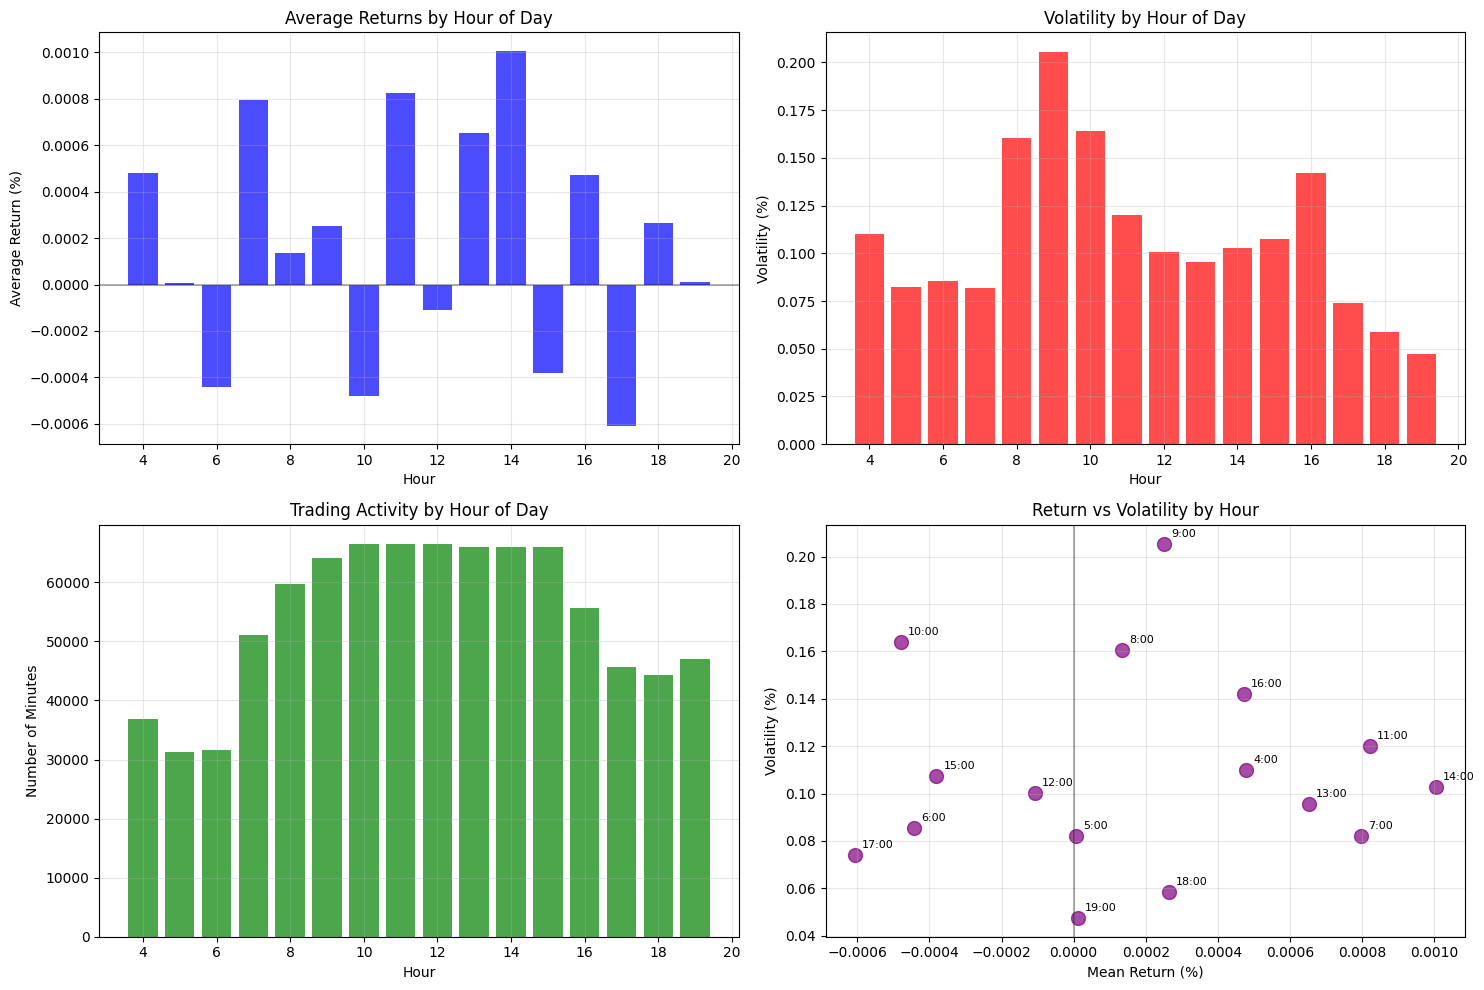

In [10]:
# Plot intraday patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Average returns by hour
axes[0, 0].bar(hourly_stats.index, hourly_stats['mean_return_pct'], alpha=0.7, color='blue')
axes[0, 0].set_title('Average Returns by Hour of Day')
axes[0, 0].set_xlabel('Hour')
axes[0, 0].set_ylabel('Average Return (%)')
axes[0, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[0, 0].grid(True, alpha=0.3)

# Volatility by hour
axes[0, 1].bar(hourly_stats.index, hourly_stats['volatility_pct'], alpha=0.7, color='red')
axes[0, 1].set_title('Volatility by Hour of Day')
axes[0, 1].set_xlabel('Hour')
axes[0, 1].set_ylabel('Volatility (%)')
axes[0, 1].grid(True, alpha=0.3)

# Trading activity by hour
axes[1, 0].bar(hourly_stats.index, hourly_stats['count'], alpha=0.7, color='green')
axes[1, 0].set_title('Trading Activity by Hour of Day')
axes[1, 0].set_xlabel('Hour')
axes[1, 0].set_ylabel('Number of Minutes')
axes[1, 0].grid(True, alpha=0.3)

# Combined view: volatility vs returns
axes[1, 1].scatter(hourly_stats['mean_return_pct'], hourly_stats['volatility_pct'], 
                  s=100, alpha=0.7, color='purple')
for hour, row in hourly_stats.iterrows():
    axes[1, 1].annotate(f'{hour}:00', (row['mean_return_pct'], row['volatility_pct']), 
                       xytext=(5, 5), textcoords='offset points', fontsize=8)
axes[1, 1].set_title('Return vs Volatility by Hour')
axes[1, 1].set_xlabel('Mean Return (%)')
axes[1, 1].set_ylabel('Volatility (%)')
axes[1, 1].axvline(x=0, color='black', linestyle='-', alpha=0.3)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# Extended hours analysis
print(f"\n=== EXTENDED HOURS ANALYSIS ===")
regular_hours = returns_with_time[(returns_with_time['hour'] >= 9) & (returns_with_time['hour'] < 16)]
extended_hours = returns_with_time[(returns_with_time['hour'] < 9) | (returns_with_time['hour'] >= 16)]

print("Regular hours (9:00 AM - 4:00 PM):")
print(f"  Mean return: {regular_hours['returns'].mean()*100:.4f}%")
print(f"  Volatility: {regular_hours['returns'].std()*100:.4f}%")
print(f"  Count: {len(regular_hours):,}")

print("Extended hours (pre-market + after-hours):")
print(f"  Mean return: {extended_hours['returns'].mean()*100:.4f}%")
print(f"  Volatility: {extended_hours['returns'].std()*100:.4f}%")
print(f"  Count: {len(extended_hours):,}")

# Calculate percentage split
total_records = len(returns_with_time)
regular_pct = len(regular_hours) / total_records * 100
extended_pct = len(extended_hours) / total_records * 100

print(f"\nTrading session breakdown:")
print(f"  Regular hours: {regular_pct:.1f}% of all trading")
print(f"  Extended hours: {extended_pct:.1f}% of all trading")



=== EXTENDED HOURS ANALYSIS ===
Regular hours (9:00 AM - 4:00 PM):
  Mean return: 0.0003%
  Volatility: 0.1332%
  Count: 461,467
Extended hours (pre-market + after-hours):
  Mean return: 0.0002%
  Volatility: 0.1045%
  Count: 403,208

Trading session breakdown:
  Regular hours: 53.4% of all trading
  Extended hours: 46.6% of all trading


In [12]:
# Ensure we have volume in our dataset
if 'volume' in all_data_sorted.columns:
    print("=== MICROSTRUCTURE ANALYSIS ===")
    print(f"Volume data available: {all_data_sorted['volume'].isnull().mean():.2%} missing values")
    
    # Add volume to our returns dataframe
    returns_with_time_vol = all_data_sorted[['datetime', 'returns', 'volume', 'open', 'close']].dropna()
    
    # Create price impact and direction variables
    returns_with_time_vol['abs_return'] = returns_with_time_vol['returns'].abs()
    returns_with_time_vol['direction'] = np.sign(returns_with_time_vol['close'] - returns_with_time_vol['open'])
    returns_with_time_vol['up_volume'] = returns_with_time_vol['volume'] * (returns_with_time_vol['direction'] > 0)
    returns_with_time_vol['down_volume'] = returns_with_time_vol['volume'] * (returns_with_time_vol['direction'] < 0)
    
    # Extract hour for analysis
    returns_with_time_vol['hour'] = returns_with_time_vol['datetime'].dt.hour
    returns_with_time_vol['minute_of_day'] = returns_with_time_vol['datetime'].dt.hour * 60 + returns_with_time_vol['datetime'].dt.minute
    
    print(f"Data points for microstructure analysis: {len(returns_with_time_vol):,}")
else:
    print("Volume data not available in the dataset. Skipping volume-based analysis.")


=== MICROSTRUCTURE ANALYSIS ===
Volume data available: 0.00% missing values
Data points for microstructure analysis: 864,675


In [13]:
# Analyze price impact and volatility clustering
if 'volume' in all_data_sorted.columns:
    # 1. Volatility clustering analysis
    # Calculate rolling volatility (5-minute window)
    returns_with_time_vol['rolling_vol_5min'] = returns_with_time_vol.groupby(returns_with_time_vol['datetime'].dt.date)['returns'].transform(
        lambda x: x.rolling(window=5, min_periods=3).std()
    )

    # Group by hour for plotting
    hourly_microstructure = returns_with_time_vol.groupby('hour').agg({
        'abs_return': 'mean',
        'rolling_vol_5min': 'mean',
        'volume': 'mean',
        'up_volume': 'mean',
        'down_volume': 'mean'
    })
    
    # Calculate up/down volume ratio
    hourly_microstructure['up_down_ratio'] = hourly_microstructure['up_volume'] / hourly_microstructure['down_volume']
    
    # Scale for better visualization
    for col in ['abs_return', 'rolling_vol_5min']:
        hourly_microstructure[f'{col}_pct'] = hourly_microstructure[col] * 100
        
    print("\n=== HOURLY MICROSTRUCTURE METRICS ===")
    print(hourly_microstructure[['abs_return_pct', 'rolling_vol_5min_pct', 'volume', 'up_down_ratio']])



=== HOURLY MICROSTRUCTURE METRICS ===
      abs_return_pct  rolling_vol_5min_pct        volume  up_down_ratio
hour                                                                   
4           0.071650              0.087778  1.708333e+04       0.954076
5           0.053592              0.066853  1.197173e+04       0.941584
6           0.053853              0.067078  1.255697e+04       0.938025
7           0.054735              0.068240  3.055287e+04       0.964905
8           0.073332              0.095972  7.777587e+04       1.046701
9           0.133551              0.158460  1.191782e+06       1.037108
10          0.118436              0.142168  1.278469e+06       1.020586
11          0.085982              0.102977  8.888470e+05       1.059353
12          0.071857              0.086307  7.043061e+05       1.041681
13          0.066445              0.079546  6.405763e+05       1.047504
14          0.069262              0.082665  6.949855e+05       1.048255
15          0.075471     

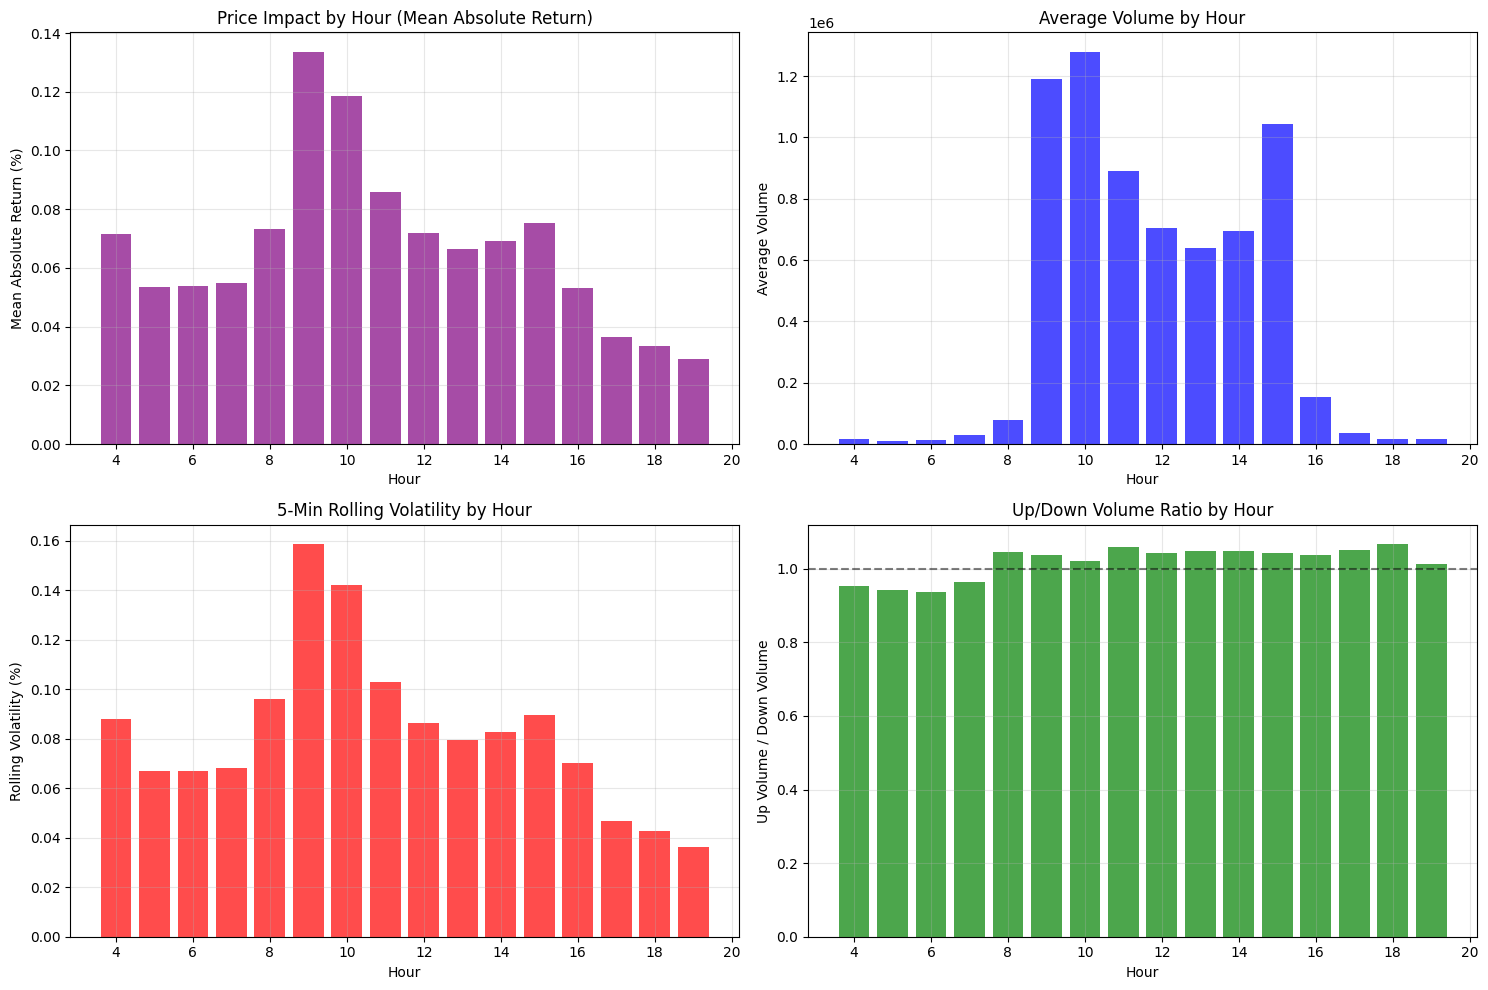

In [14]:
# Plot microstructure metrics
if 'volume' in all_data_sorted.columns:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Price Impact by Hour
    axes[0, 0].bar(hourly_microstructure.index, hourly_microstructure['abs_return_pct'], alpha=0.7, color='purple')
    axes[0, 0].set_title('Price Impact by Hour (Mean Absolute Return)')
    axes[0, 0].set_xlabel('Hour')
    axes[0, 0].set_ylabel('Mean Absolute Return (%)')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Volume by Hour
    axes[0, 1].bar(hourly_microstructure.index, hourly_microstructure['volume'], alpha=0.7, color='blue')
    axes[0, 1].set_title('Average Volume by Hour')
    axes[0, 1].set_xlabel('Hour')
    axes[0, 1].set_ylabel('Average Volume')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Rolling Volatility by Hour
    axes[1, 0].bar(hourly_microstructure.index, hourly_microstructure['rolling_vol_5min_pct'], alpha=0.7, color='red')
    axes[1, 0].set_title('5-Min Rolling Volatility by Hour')
    axes[1, 0].set_xlabel('Hour')
    axes[1, 0].set_ylabel('Rolling Volatility (%)')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Up/Down Volume Ratio
    axes[1, 1].bar(hourly_microstructure.index, hourly_microstructure['up_down_ratio'], alpha=0.7, color='green')
    axes[1, 1].axhline(y=1.0, color='black', linestyle='--', alpha=0.5)
    axes[1, 1].set_title('Up/Down Volume Ratio by Hour')
    axes[1, 1].set_xlabel('Hour')
    axes[1, 1].set_ylabel('Up Volume / Down Volume')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


In [15]:
# Prepare data for strategy testing
# First, get daily open and close prices
print("=== INTRADAY STRATEGY BACKTESTING ===")

# Create a daily dataframe with open and close prices
daily_data = all_data_sorted.groupby('date').agg({
    'open': 'first',   # First price of the day
    'close': 'last',   # Last price of the day
})

# Add next day's open for overnight strategy
daily_data['next_open'] = daily_data['open'].shift(-1)

# Calculate strategy returns
daily_data['open_to_close_return'] = (daily_data['close'] / daily_data['open']) - 1
daily_data['close_to_open_return'] = (daily_data['next_open'] / daily_data['close']) - 1

# For the first hour reversal strategy, we need the first hour's return
# First, identify the market open time (9:30 AM)
market_open_hour = 9
market_open_minute = 30

# Calculate first hour's close (10:30 AM)
first_hour_data = all_data_sorted[
    (all_data_sorted['datetime'].dt.hour == market_open_hour) & 
    (all_data_sorted['datetime'].dt.minute >= market_open_minute) |
    (all_data_sorted['datetime'].dt.hour == market_open_hour + 1) & 
    (all_data_sorted['datetime'].dt.minute < market_open_minute)
]

# Get first and last prices of the first hour
first_hour_by_day = first_hour_data.groupby('date').agg({
    'open': 'first',
    'close': 'last'
})

# Calculate first hour return
first_hour_by_day['first_hour_return'] = (first_hour_by_day['close'] / first_hour_by_day['open']) - 1

# Merge with daily data
daily_data = daily_data.merge(first_hour_by_day[['first_hour_return']], 
                              left_index=True, 
                              right_index=True,
                              how='left')

# For first hour reversal strategy, we invest if first hour return is negative
daily_data['reversal_signal'] = daily_data['first_hour_return'] < 0
daily_data['first_hour_to_close'] = daily_data.apply(
    lambda row: (row['close'] / first_hour_by_day.loc[row.name, 'close'] - 1) 
    if row.name in first_hour_by_day.index else np.nan, 
    axis=1
)
daily_data['reversal_return'] = daily_data['reversal_signal'] * daily_data['first_hour_to_close']

# Print strategy results
print("\n1. Open-to-Close Strategy:")
print(f"  Mean daily return: {daily_data['open_to_close_return'].mean()*100:.4f}%")
print(f"  Annualized return: {daily_data['open_to_close_return'].mean()*252*100:.2f}%")
print(f"  Sharpe ratio: {daily_data['open_to_close_return'].mean() / daily_data['open_to_close_return'].std() * np.sqrt(252):.2f}")
print(f"  Win rate: {(daily_data['open_to_close_return'] > 0).mean()*100:.2f}%")

print("\n2. Close-to-Open Strategy:")
print(f"  Mean daily return: {daily_data['close_to_open_return'].mean()*100:.4f}%")
print(f"  Annualized return: {daily_data['close_to_open_return'].mean()*252*100:.2f}%")
print(f"  Sharpe ratio: {daily_data['close_to_open_return'].mean() / daily_data['close_to_open_return'].std() * np.sqrt(252):.2f}")
print(f"  Win rate: {(daily_data['close_to_open_return'] > 0).mean()*100:.2f}%")

print("\n3. First Hour Reversal Strategy:")
reversal_returns = daily_data['reversal_return'].dropna()
if len(reversal_returns) > 0:
    print(f"  Trade frequency: {daily_data['reversal_signal'].mean()*100:.2f}% of days")
    print(f"  Mean return when traded: {reversal_returns.mean()*100:.4f}%")
    print(f"  Annualized return: {reversal_returns.mean()*252*daily_data['reversal_signal'].mean()*100:.2f}%")
    print(f"  Win rate: {(reversal_returns > 0).mean()*100:.2f}%")
else:
    print("  Not enough data for first hour reversal strategy")


=== INTRADAY STRATEGY BACKTESTING ===

1. Open-to-Close Strategy:
  Mean daily return: 0.1439%
  Annualized return: 36.25%
  Sharpe ratio: 0.67
  Win rate: 50.23%

2. Close-to-Open Strategy:
  Mean daily return: 0.1293%
  Annualized return: 32.58%
  Sharpe ratio: 2.27
  Win rate: 60.07%

3. First Hour Reversal Strategy:
  Trade frequency: 50.05% of days
  Mean return when traded: -0.0069%
  Annualized return: -0.87%
  Win rate: 23.94%


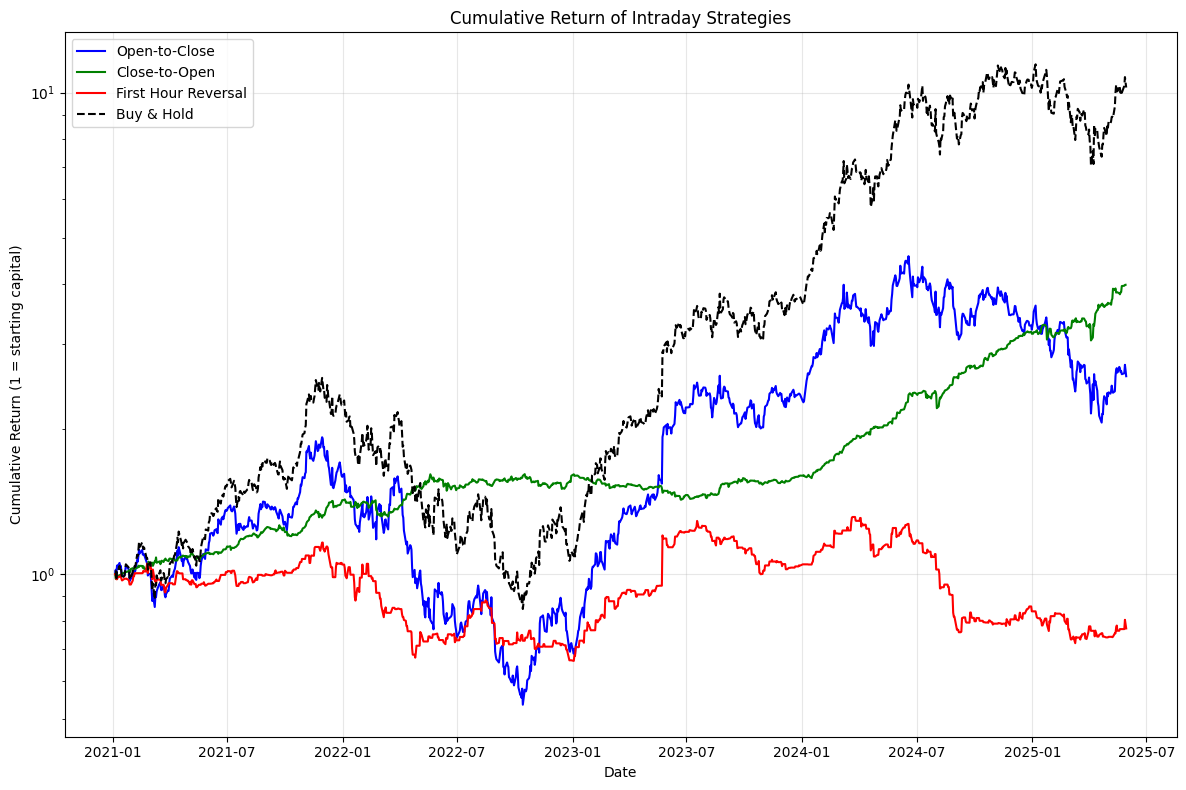

In [16]:
# Visualize strategy performance
# Calculate cumulative returns
daily_data['open_to_close_cum_return'] = (1 + daily_data['open_to_close_return']).cumprod()
daily_data['close_to_open_cum_return'] = (1 + daily_data['close_to_open_return']).cumprod()

# For the reversal strategy, we need to handle days where we don't trade
daily_data['reversal_return_filled'] = daily_data['reversal_return'].fillna(0)
daily_data['reversal_cum_return'] = (1 + daily_data['reversal_return_filled']).cumprod()

# Also calculate a buy-and-hold benchmark
daily_data['buy_and_hold_return'] = daily_data['close'].pct_change()
daily_data['buy_and_hold_cum_return'] = (1 + daily_data['buy_and_hold_return']).cumprod()

# Plot strategy performance
plt.figure(figsize=(12, 8))

plt.plot(daily_data.index, daily_data['open_to_close_cum_return'], label='Open-to-Close', color='blue')
plt.plot(daily_data.index, daily_data['close_to_open_cum_return'], label='Close-to-Open', color='green')
plt.plot(daily_data.index, daily_data['reversal_cum_return'], label='First Hour Reversal', color='red')
plt.plot(daily_data.index, daily_data['buy_and_hold_cum_return'], label='Buy & Hold', color='black', linestyle='--')

plt.title('Cumulative Return of Intraday Strategies')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (1 = starting capital)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')  # Log scale for better visualization of returns

plt.tight_layout()
plt.show()
